In [ ]:
!pip install Pillow==5.3.0

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers

Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.2.incompletePZMK0M/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


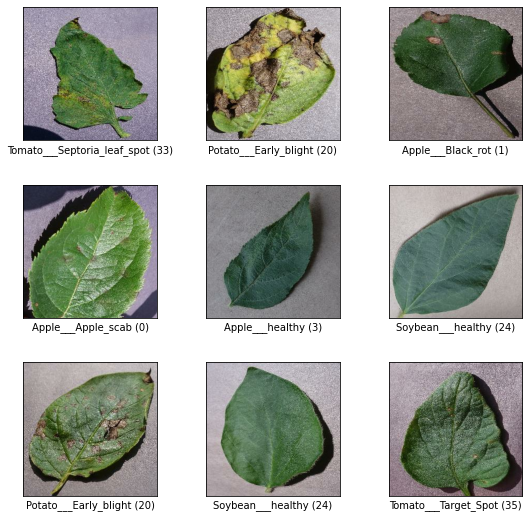

In [3]:
plant_village, plant_village_info = tfds.load('plant_village', split='train', with_info=True,shuffle_files=True,as_supervised=True)
fig = tfds.show_examples(plant_village, plant_village_info)

In [4]:
ds_size= len(plant_village)

In [5]:
classes = plant_village_info .features['label'].num_classes
print(classes)

38


In [6]:
train_size = int(0.7 * ds_size)
test_size1 = int(0.3 * ds_size)
train_dataset = plant_village.take(train_size)
test_dataset1 = plant_village.skip(train_size)
test_dataset1 = plant_village.take(test_size1)
test_size = int(0.5 * test_size1)
val_size = int(0.5 * test_size1)
test_dataset = test_dataset1.take(test_size)
test_dataset = test_dataset1.skip(test_size)
val_dataset = test_dataset1.take(val_size)

In [7]:
len(train_dataset)

38012

In [8]:
len(test_dataset)

8145

In [9]:
len(val_dataset)

8145

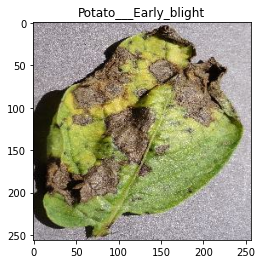

In [10]:
get_label_name = plant_village_info.features['label'].int2str

image, label = next(iter(train_dataset))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [11]:
IMG_SIZE = 299
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label


def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [12]:
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_dataset, (counter, counter)))

In [13]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [14]:
val_ds = (
    val_dataset
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_dataset
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [15]:
m = tf.keras.applications.InceptionV3(
    include_top=True, weights='imagenet', input_tensor=None,
    classes=1000)

96116736/96112376 [==============================] - 1s 0us/step


In [16]:
m.trainable= False

In [17]:
m.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
from tensorflow.keras import Model

In [20]:
m.layers.pop()
model_m = Model(m.input, m.layers[-2].output)
model_m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [21]:
model_m= tf.keras.models.Sequential(model_m)
model_m.add(tf.keras.layers.Dense(units=512))
model_m.add(tf.keras.layers.Activation('relu'))
model_m.add(tf.keras.layers.Dense(units=39))
model_m.add(tf.keras.layers.Activation('softmax'))

In [22]:
model_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
activation_94 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39)                20007     
_________________________________________________________________
activation_95 (Activation)   (None, 39)                0         
Total params: 22,871,879
Trainable params: 1,069,095
Non-trainable params: 21,802,784
_________________________________________________________________


In [23]:
model_m.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
epochs=25
history = model_m.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
1188/1188 [==============================] - 214s 148ms/step - loss: 0.9652 - accuracy: 0.7320 - val_loss: 0.2537 - val_accuracy: 0.9182
Epoch 2/25
1188/1188 [==============================] - 175s 147ms/step - loss: 0.3288 - accuracy: 0.8933 - val_loss: 0.1890 - val_accuracy: 0.9351
Epoch 3/25
1188/1188 [==============================] - 175s 147ms/step - loss: 0.2725 - accuracy: 0.9083 - val_loss: 0.1885 - val_accuracy: 0.9375
Epoch 4/25
1188/1188 [==============================] - 175s 147ms/step - loss: 0.2376 - accuracy: 0.9208 - val_loss: 0.1528 - val_accuracy: 0.9489
Epoch 5/25
1188/1188 [==============================] - 175s 147ms/step - loss: 0.2200 - accuracy: 0.9257 - val_loss: 0.1386 - val_accuracy: 0.9549
Epoch 6/25
1188/1188 [==============================] - 175s 147ms/step - loss: 0.2026 - accuracy: 0.9324 - val_loss: 0.1119 - val_accuracy: 0.9619
Epoch 7/25
1188/1188 [==============================] - 175s 147ms/step - loss: 0.1880 - accuracy: 0.9379 - val_

In [25]:
model_m.evaluate(test_ds)

255/255 [==============================] - 34s 121ms/step - loss: 0.0869 - accuracy: 0.9692


[0.0868687778711319, 0.9691835641860962]

In [27]:
model_m.save('/content/InceptionV3')

INFO:tensorflow:Assets written to: /content/InceptionV3/assets


INFO:tensorflow:Assets written to: /content/InceptionV3/assets
